# Transformer Model!
## Needs:


In [22]:
## imports 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import math
import copy
import numpy as np
import pandas as pd

In [23]:
## The building blocks of a transformer are:
# 1. Multi-head self-attention
# 2. Feedforward neural network
# 3. Positional Encoding
# 4. Layer normalization
# 5. Residual connections
# 6. Dropout

## SINE WAVE

In [24]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Define time vector (e.g., from 0 to 10 seconds, with 1000 points)
time = np.linspace(0, 86400, 1000) # int(1e6)

# Define sine wave parameters
frequency = 1 / 3600 # Hz (change this to adjust the wave frequency)
amplitude = 2.3547  # unitless (change this to adjust the wave amplitude)

# Generate sine wave values
sine_wave = amplitude * np.sin(2 * np.pi * frequency * time)

# Create DataFrame
sine_df_raw = pd.DataFrame({
    'Time (seconds)': time,
    'Sine Amplitude': sine_wave
})

# Total seconds in a day and week
SECONDS_PER_HOUR = 3600
SECONDS_PER_DAY = 86400
SECONDS_PER_WEEK = SECONDS_PER_DAY * 7

# Compute cyclical features
sine_df_raw['dow_cos'] = np.cos(2 * np.pi * (sine_df_raw['Time (seconds)'] % SECONDS_PER_WEEK) / SECONDS_PER_WEEK)
sine_df_raw['dow_sin'] = np.sin(2 * np.pi * (sine_df_raw['Time (seconds)'] % SECONDS_PER_WEEK) / SECONDS_PER_WEEK)
sine_df_raw['hour_cos'] = np.cos(2 * np.pi * (sine_df_raw['Time (seconds)'] % SECONDS_PER_DAY) / SECONDS_PER_DAY)

print(sine_df_raw)
# sine_df = (sine_df_raw - sine_df_raw.mean()) / sine_df_raw.std()
sine_df = sine_df_raw.copy()

     Time (seconds)  Sine Amplitude   dow_cos   dow_sin  hour_cos
0          0.000000    0.000000e+00  1.000000  0.000000  1.000000
1         86.486486    3.540876e-01  1.000000  0.000898  0.999980
2        172.972973    7.001226e-01  0.999998  0.001797  0.999921
3        259.459459    1.030235e+00  0.999996  0.002695  0.999822
4        345.945946    1.336919e+00  0.999994  0.003594  0.999684
..              ...             ...       ...       ...       ...
995    86054.054054   -1.336919e+00  0.626296  0.779586  0.999684
996    86140.540541   -1.030235e+00  0.625595  0.780148  0.999822
997    86227.027027   -7.001226e-01  0.624894  0.780710  0.999921
998    86313.513514   -3.540876e-01  0.624192  0.781271  0.999980
999    86400.000000   -1.384164e-14  0.623490  0.781831  1.000000

[1000 rows x 5 columns]


Plotting first 300000 points out of 1,000,000 total points.


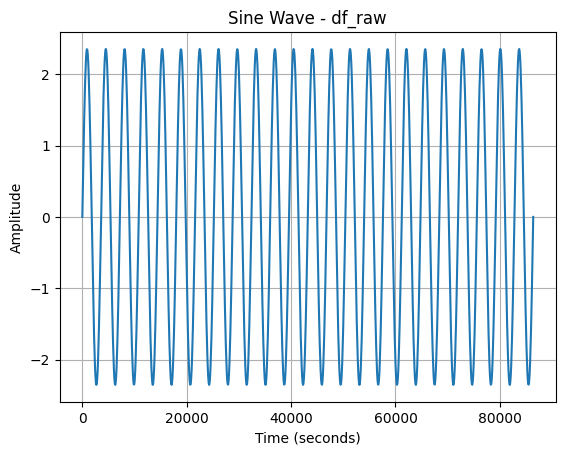

Plotting first 300000 points out of 1,000,000 total points.


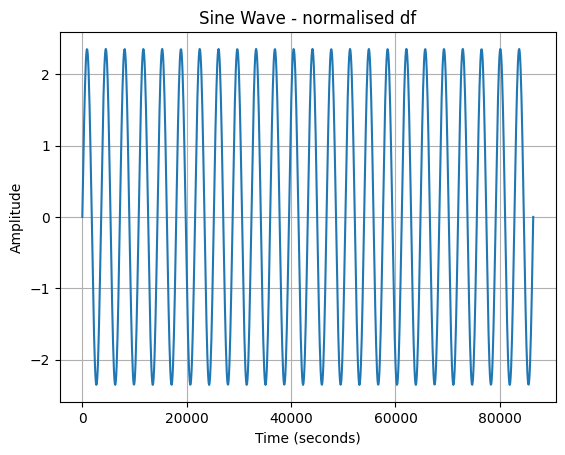

In [25]:
## Plot the sine wave   
## Showing original plot of sine wave
# Plot 5 hours worth of data
import matplotlib.pyplot as plt


## ----- Plotting raw sine wave data ---------------------
points_to_plot = int(3e5)
print(f"Plotting first {points_to_plot} points out of 1,000,000 total points.")
plt.plot(sine_df_raw['Time (seconds)'][:points_to_plot], sine_df_raw['Sine Amplitude'][:points_to_plot])
plt.title('Sine Wave - df_raw')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


## ----- Plotting normalised sine wave data ---------------------
points_to_plot = int(3e5)
print(f"Plotting first {points_to_plot} points out of 1,000,000 total points.")
plt.plot(sine_df['Time (seconds)'][:points_to_plot], sine_df['Sine Amplitude'][:points_to_plot])
plt.title('Sine Wave - normalised df')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.grid()
plt.show()


In [26]:
## Before passing the data to the model, I need to drop time features 

sine_df = sine_df.drop(columns=['Time (seconds)'])


In [27]:
sine_df

,Sine Amplitude,dow_cos,dow_sin,hour_cos
0,0.000000e+00,1.000000,0.000000,1.000000
1,3.540876e-01,1.000000,0.000898,0.999980
2,7.001226e-01,0.999998,0.001797,0.999921
3,1.030235e+00,0.999996,0.002695,0.999822
4,1.336919e+00,0.999994,0.003594,0.999684
...,...,...,...,...
995,-1.336919e+00,0.626296,0.779586,0.999684
996,-1.030235e+00,0.625595,0.780148,0.999822
997,-7.001226e-01,0.624894,0.780710,0.999921
998,-3.540876e-01,0.624192,0.781271,0.999980


## TRANSFORMER VARIATIONAL AUTOENCODER

In [28]:
import torch
import torch.nn as nn
import math


## THIS IS THE FINAL ONE WITH 2 SEPRATE DECODERS 
## ONE RECONSTRUCTING THE OTHER FORECASTING THE NEXT STEPS

# === Positional Encoding for continuous features ===
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=1000):
        super().__init__()

        ## CREATING A POSITONAL ENCODING MATRIX FULL OF 0
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * - (math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

# === Transformer VAE with Dual-Head Decoder ===
class TransformerVAE(nn.Module):
    def __init__(self, feature_dim=43, d_model=64, latent_dim=16, num_heads=4, num_layers=2, dropout=0.1):
        super().__init__()
        
        ## ENCODER LAYER
        self.input_proj = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=128, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_mu = nn.Linear(d_model, latent_dim)
        self.fc_logvar = nn.Linear(d_model, latent_dim)

        self.latent_to_hidden = nn.Linear(latent_dim, d_model)

        ## DECODER LAYER
        ## WITH 2 SEPARATE DECODERS FOR RECONSTRUCTION AND FORECASTING
        # Each decoder has its own layer and output projection
        # This allows for different configurations if needed in the future
        decoder_layer_recon = nn.TransformerDecoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=128, dropout=dropout)
        decoder_layer_forecast = nn.TransformerDecoderLayer(d_model=d_model, nhead=num_heads, dim_feedforward=128, dropout=dropout)

        self.transformer_decoder_recon = nn.TransformerDecoder(decoder_layer_recon, num_layers=num_layers)
        self.transformer_decoder_forecast = nn.TransformerDecoder(decoder_layer_forecast, num_layers=num_layers)

        self.output_proj_recon = nn.Linear(d_model, feature_dim)
        self.output_proj_forecast = nn.Linear(d_model, feature_dim)


    def encode(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        x = x.transpose(0, 1)
        encoded = self.transformer_encoder(x)
        pooled = encoded.mean(dim=0)
        mu = self.fc_mu(pooled)
        logvar = self.fc_logvar(pooled)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode_reconstruct(self, z, seq_len, tgt_input):
        hidden = self.latent_to_hidden(z).unsqueeze(0)
        construct_output = self.transformer_decoder_recon(tgt_input, memory=hidden)
        construct_output = self.output_proj_recon(construct_output.transpose(0, 1))
        return construct_output

    def decode_forecast(self, z, forecast_len):
        hidden = self.latent_to_hidden(z).unsqueeze(0)
        tgt_input = torch.zeros(forecast_len, hidden.size(1), hidden.size(2), device=z.device)
        forecast_output = self.transformer_decoder_forecast(tgt_input, memory=hidden)
        forecast_output = self.output_proj_forecast(forecast_output.transpose(0, 1))
        return forecast_output

    def forward(self, x, forecast_len=5):
        seq_len = x.size(1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)

        x_input = self.input_proj(x)
        x_input = self.pos_encoder(x_input)
        x_input = x_input.transpose(0, 1)

        recon = self.decode_reconstruct(z, seq_len, tgt_input=x_input)
        forecast = self.decode_forecast(z, forecast_len)

        return recon, forecast, mu, logvar


In [29]:
## Creating Dataset and DataLoader
## sine_df
import torch
import pandas as pd

# Assuming merged_dataset_small is your preloaded DataFrame
data_tensor = torch.tensor(sine_df.values, dtype=torch.float32) 
print(data_tensor.shape)  # Example: [100000, 5]

seq_len = 30  # e.g., 1-hour sequences if data is minute-level
num_features = 4

# Drop leftover rows that don't complete a full sequence
total_timesteps = data_tensor.shape[0] - (data_tensor.shape[0] % seq_len)
data_tensor = data_tensor[:total_timesteps]

# Reshape into sequences
sequences = data_tensor.view(-1, seq_len, num_features)  # [num_sequences, seq_len, num_features]
print(sequences.shape)  # [num_sequences, 60, 43]

from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(sequences)
loader = DataLoader(dataset, batch_size=32, shuffle=True)
print(f"Loader contains {len(loader)} batches")

for batch in loader:
    x = batch[0]
    print(f"Batch shape: {x.shape}")  # Should be [batch_size, seq_len, feature_dim]
    break  # Just check the first batch



torch.Size([1000, 4])
torch.Size([33, 30, 4])
Loader contains 2 batches
Batch shape: torch.Size([32, 30, 4])


In [30]:
# vae = TransformerVAE(
#     feature_dim=4,
#     d_model=32,  # Reduced from 128
#     latent_dim=2,  # Reduced from 128 (only need to encode freq, phase, amp)
#     num_heads=4,   # Reduced from 8
#     num_layers=4,  # Reduced from 8
#     dropout=0.0    # Remove dropout for small dataset
# )

# optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
# recon_loss_fn = nn.MSELoss()
# forecast_loss_fn = nn.MSELoss()

# results = []
# vae.train()

# ## This is because I think I should forecast next step and then reinject it in the model
# forecast_steps = 30

# print(f"Loader contains {len(loader)} batches")

# for epoch in range(100):
#     epoch_loss = 0
#     recon_loss_total = 0
#     forecast_loss_total = 0
#     kld_total = 0
#     batch_counter = 0

#     for batch in loader:
#         x = batch[0]  # [batch_size, seq_len, feature_dim]

#         if x.size(1) < forecast_steps:
#             continue

#         future_target = x[:, -forecast_steps:, :]

#         recon, forecast, mu, logvar = vae(x, forecast_len=forecast_steps)

#         recon_loss = recon_loss_fn(recon, x)
#         forecast_loss = forecast_loss_fn(forecast, future_target)
#         kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

#         loss = recon_loss + forecast_loss + 0.01 * kld

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()
#         recon_loss_total += recon_loss.item()
#         forecast_loss_total += forecast_loss.item()
#         kld_total += kld.item()
#         batch_counter += 1

#         if batch_counter % 100 == 0:
#             print(f"Batch {batch_counter}, Loss: {loss.item():.4f}, Recon: {recon_loss.item():.4f}, Forecast: {forecast_loss.item():.4f}, KLD: {kld.item():.4f}")

#     if batch_counter == 0:
#         print(f"Epoch {epoch+1}: Skipped, no valid batches")
#         continue

#     avg_loss = epoch_loss / batch_counter
#     avg_recon = recon_loss_total / batch_counter
#     avg_forecast = forecast_loss_total / batch_counter
#     avg_kld = kld_total / batch_counter

#     print(f"Epoch {epoch+1} complete, Total Loss: {avg_loss:.4f}, Recon: {avg_recon:.4f}, Forecast: {avg_forecast:.4f}, KLD: {avg_kld:.4f}")

#     results.append({
#         "epoch": epoch+1,
#         "total_loss": avg_loss,
#         "recon_loss": avg_recon,
#         "forecast_loss": avg_forecast,
#         "kld_loss": avg_kld
#     })

# # After training
# import pandas as pd
# results_df = pd.DataFrame(results)
# print(results_df.head())
# results_df.to_csv("vae_multi_head_pointbypointtry.csv", index=False)
# print("CSV saved successfully")

In [31]:
# # === Evaluating the Transformer VAE ===
# vae.eval()
# with torch.no_grad():
    
#     # Starting sequence: last 30 known timesteps from your dataset
#     start_idx = 0
#     initial_seq = data_tensor[start_idx : start_idx + seq_len].unsqueeze(0)  # [1, seq_len, feature_dim]

#     generated_seq = initial_seq.clone()  # Holds growing sequence

#     num_rollout_steps = 50

#     for step in range(num_rollout_steps):
        
#         input_seq = generated_seq[:, -seq_len:, :]  # Take last 30 points
#         _, forecast, _, _ = vae(input_seq, forecast_len=1)
        
#         next_step = forecast[:, -1:, :]  # Shape: [1, 1, feature_dim]
        
#         generated_seq = torch.cat((generated_seq, next_step), dim=1)  # Append prediction

#     print(f"Generated sequence shape: {generated_seq.shape}")  # [1, seq_len + num_rollout_steps, feature_dim]

#     predicted_future = generated_seq[:, seq_len:, :]  # Extract only future points


In [32]:
# import matplotlib.pyplot as plt

# # Extract predicted next steps
# predicted_amplitude = predicted_future[0, :, 0].cpu().numpy()  # Shape: [num_rollout_steps]

# # Extract true next steps from dataset
# true_future = data_tensor[start_idx + seq_len : start_idx + seq_len + num_rollout_steps, 0].cpu().numpy()

# # Plot comparison
# plt.figure(figsize=(10, 5))
# plt.plot(range(num_rollout_steps), true_future, label='True Sine Amplitude', linewidth=2)
# plt.plot(range(num_rollout_steps), predicted_amplitude, label='Predicted Sine Amplitude', linestyle='dashed', linewidth=2)
# plt.title('Next-Step Forecast Rollout (Sine Amplitude)')
# plt.xlabel('Timestep')
# plt.ylabel('Amplitude')
# plt.legend()
# plt.grid()
# plt.show()


In [40]:
## Defining VAE transoferm focused model
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
from torch.utils.data import DataLoader, TensorDataset

class EnhancedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()
        self.d_model = d_model
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, x):
        if x.size(-1) != self.d_model:
            raise ValueError(f"Expected input dimension {self.d_model}, got {x.size(-1)}")
        return x + self.pe[:, :x.size(1)]

class PhaseAwareTransformerVAE(nn.Module):
    def __init__(self, 
                 input_dim=4, 
                 d_model=128,
                 latent_dim=16,
                 num_heads=8,
                 num_layers=6,
                 max_seq_len=150,
                 dropout=0.2):
        super().__init__()
        
        # Input processing
        self.input_proj = nn.Sequential(
            nn.Linear(input_dim, d_model),
            nn.LayerNorm(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.pos_encoder = EnhancedPositionalEncoding(d_model, max_seq_len)
        
        # Encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=num_heads,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Latent space
        self.latent_proj = nn.Sequential(
            nn.Linear(d_model, d_model*2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(d_model*2, latent_dim)
        self.fc_logvar = nn.Linear(d_model*2, latent_dim)
        
        # Decoder
        self.latent_to_hidden = nn.Linear(latent_dim, d_model)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=num_heads,
            dim_feedforward=d_model*4,
            dropout=dropout,
            batch_first=True,
            norm_first=True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        
        # Output projections
        self.amp_proj = nn.Linear(d_model, 1)
        self.phase_proj = nn.Linear(d_model, 1)
        self.aux_proj = nn.Linear(d_model, input_dim-2)
        
        # Causal masking
        self.register_buffer("future_mask", 
                           torch.triu(torch.ones(max_seq_len, max_seq_len) * float('-inf'), 
                           diagonal=1))
        
        # Phase correction
        self.phase_correction = nn.Parameter(torch.tensor(0.1))
        
        # Initialize weights
        self._init_weights()
        
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
                
    def encode(self, x):
        x = self.input_proj(x)
        x = self.pos_encoder(x)
        encoded = self.encoder(x)
        pooled = self.latent_proj(encoded.mean(dim=1))
        return self.fc_mu(pooled), self.fc_logvar(pooled)
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z, target_seq=None, forecast_steps=30, teacher_forcing_ratio=0.5):
        batch_size = z.size(0)
        hidden = self.latent_to_hidden(z).unsqueeze(1)
        
        outputs = torch.zeros(batch_size, forecast_steps, 
                            self.amp_proj.out_features + 
                            self.phase_proj.out_features + 
                            self.aux_proj.out_features,
                            device=z.device)
        
        for t in range(forecast_steps):
            # Teacher forcing
            if target_seq is not None and torch.rand(1) < teacher_forcing_ratio:
                decoder_input = target_seq[:, :t+1]
            else:
                decoder_input = outputs[:, :t+1]
            
            decoder_input = self.input_proj(decoder_input)
            decoder_input = self.pos_encoder(decoder_input)
            
            # Causal decoding
            output = self.decoder(
                decoder_input,
                hidden.expand(-1, t+1, -1),
                tgt_mask=self.future_mask[:t+1, :t+1]
            )
            
            # Phase-aware outputs
            amp = torch.sigmoid(self.amp_proj(output[:, -1]))
            phase = self.phase_proj(output[:, -1])
            aux = self.aux_proj(output[:, -1])
            
            # Adaptive phase correction
            if t > 0 and t % 5 == 0:
                phase = phase * (1 - self.phase_correction) + outputs[:, t-1, 1:2] * self.phase_correction
            
            outputs[:, t] = torch.cat([amp, phase, aux], dim=-1)
            
        return outputs
    
    def forward(self, x, forecast_steps=30, teacher_forcing_ratio=0.5):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        
        target_seq = torch.cat([x[:, 1:], torch.zeros_like(x[:, -1:])], dim=1)
        recon = self.decode(z, target_seq=target_seq[:, :forecast_steps], 
                          forecast_steps=forecast_steps,
                          teacher_forcing_ratio=teacher_forcing_ratio)
        
        return recon, mu, logvar

def prepare_data(data_tensor, seq_len=30, batch_size=32, val_ratio=0.2):
    """Prepare DataLoader with train/validation split"""
    total_sequences = data_tensor.shape[0] // seq_len
    sequences = data_tensor[:total_sequences*seq_len].view(-1, seq_len, data_tensor.shape[-1])
    
    # Split into train and validation
    val_size = int(val_ratio * len(sequences))
    train_size = len(sequences) - val_size
    
    train_dataset = TensorDataset(sequences[:train_size])
    val_dataset = TensorDataset(sequences[train_size:])
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    
    return train_loader, val_loader

def train_model(model, train_loader, val_loader, optimizer, epochs=200, max_forecast_steps=50):
    results = []
    best_val_loss = float('inf')
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, verbose=True)
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        recon_loss_total = 0
        forecast_loss_total = 0
        kld_total = 0
        batch_count = 0
        
        # Curriculum learning
        forecast_steps = min(10 + epoch//3, max_forecast_steps)
        
        for batch in train_loader:
            x = batch[0]
            optimizer.zero_grad()
            
            # Forward pass
            recon, forecast, mu, logvar = model(x, forecast_steps=forecast_steps)
            
            # Calculate losses
            recon_loss = F.mse_loss(recon, x)
            forecast_loss = F.mse_loss(forecast, x[:, -forecast_steps:])
            kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
            
            # Combined loss
            loss = recon_loss + forecast_loss + 0.1 * kld
            
            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            
            # Accumulate metrics
            epoch_loss += loss.item()
            recon_loss_total += recon_loss.item()
            forecast_loss_total += forecast_loss.item()
            kld_total += kld.item()
            batch_count += 1
        
        # Validation
        val_loss = evaluate(model, val_loader, forecast_steps)
        scheduler.step(val_loss)
        
        # Calculate averages
        avg_loss = epoch_loss / batch_count
        avg_recon = recon_loss_total / batch_count
        avg_forecast = forecast_loss_total / batch_count
        avg_kld = kld_total / batch_count
        
        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')
        
        # Log results
        print(f"Epoch {epoch+1} complete, "
              f"Total Loss: {avg_loss:.4f}, "
              f"Recon: {avg_recon:.4f}, "
              f"Forecast: {avg_forecast:.4f}, "
              f"KLD: {avg_kld:.4f}, "
              f"Val Loss: {val_loss:.4f}")
        
        results.append({
            "epoch": epoch+1,
            "total_loss": avg_loss,
            "recon_loss": avg_recon,
            "forecast_loss": avg_forecast,
            "kld_loss": avg_kld,
            "val_loss": val_loss,
            "lr": optimizer.param_groups[0]['lr']
        })
    
    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv('training_results.csv', index=False)
    print("Training complete. Results saved to training_results.csv")
    
    return results

def evaluate(model, loader, forecast_steps):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for batch in loader:
            x = batch[0]
            recon, forecast, mu, logvar = model(x, forecast_steps=forecast_steps)
            
            # Combined validation loss (same we
# Example usage:

# 1. Prepare Data
data_tensor = torch.tensor(sine_df.values, dtype=torch.float32)
print(f"Original data shape: {data_tensor.shape}")  # [num_timesteps, num_features]

# 2. Create DataLoaders with train/validation split
seq_len = 30  # Should match your model's expected input length
batch_size = 32
train_loader, val_loader = prepare_data(
    data_tensor,
    seq_len=seq_len,
    batch_size=batch_size,
    val_ratio=0.2
)

# 3. Initialize Model with parameters matching your data
model = PhaseAwareTransformerVAE(
    input_dim=data_tensor.shape[-1],  # Automatically use correct feature dimension
    d_model=128,
    latent_dim=16,
    num_heads=8,
    num_layers=6,
    max_seq_len=seq_len,  # Important: Should match your sequence length
    dropout=0.1
)


Original data shape: torch.Size([1000, 4])


Generated sequence shape: torch.Size([1, 80, 4])


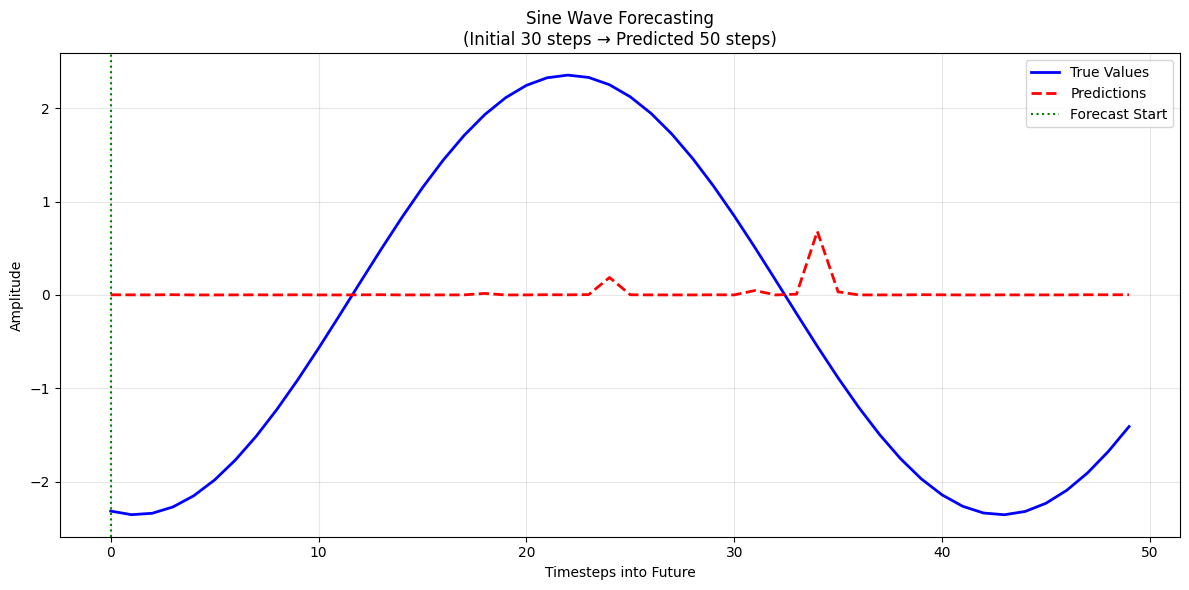

In [41]:
# === Evaluating the Transformer VAE ===
model.eval()  # Use model instead of vae to match your class name
with torch.no_grad():
    # Starting sequence: last known timesteps from your dataset
    start_idx = 0
    initial_seq = data_tensor[start_idx:start_idx + seq_len].unsqueeze(0)  # [1, seq_len, feature_dim]
    
    generated_seq = initial_seq.clone()  # Holds growing sequence
    num_rollout_steps = 50  # How many steps to predict ahead

    for step in range(num_rollout_steps):
        # Take last seq_len points as input
        input_seq = generated_seq[:, -seq_len:, :]
        
        # Get prediction (using your model's forward pass)
        recon, mu, logvar = model(input_seq, forecast_steps=1)
        
        # Get the predicted next step
        next_step = recon[:, -1:, :]  # Shape: [1, 1, feature_dim]
        
        # Append prediction to sequence
        generated_seq = torch.cat((generated_seq, next_step), dim=1)

    print(f"Generated sequence shape: {generated_seq.shape}")  # [1, seq_len + num_rollout_steps, feature_dim]
    
    # Extract only the predicted future points (excluding initial sequence)
    predicted_future = generated_seq[:, seq_len:, :]

    # Visualization
    predicted_amplitude = predicted_future[0, :, 0].cpu().numpy()
    true_future = data_tensor[start_idx + seq_len : start_idx + seq_len + num_rollout_steps, 0].cpu().numpy()

    plt.figure(figsize=(12, 6))
    plt.plot(range(num_rollout_steps), true_future, 
             label='True Values', linewidth=2, color='blue')
    plt.plot(range(num_rollout_steps), predicted_amplitude, 
             label='Predictions', linestyle='dashed', linewidth=2, color='red')
    
    # Add vertical line showing where forecasting began
    plt.axvline(x=0, color='green', linestyle=':', label='Forecast Start')
    
    plt.title(f'Sine Wave Forecasting\n(Initial {seq_len} steps → Predicted {num_rollout_steps} steps)')
    plt.xlabel('Timesteps into Future')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

In [ ]:
# def recursive_forecast_amplitude(model, x_init, steps=30, amplitude_idx=0):
#     """
#     Predict multiple future steps recursively using model's forecast head.

#     Args:
#         model: trained TransformerVAE model
#         x_init: [1, seq_len, feature_dim] - starting input sequence for context
#         steps: int - number of future steps to predict
#         amplitude_idx: int - index of amplitude feature in input features

#     Returns:
#         preds: [1, steps] - predicted amplitude values for future steps
#     """
    
#     model.eval()
#     preds = []
#     x_curr = x_init.clone()  # [1, seq_len, feature_dim]

#     with torch.no_grad():
#         for _ in range(steps):
#             recon, future_pred, _, _ = model(x_curr, pred_steps=1, teacher_force_prob=0.0)
            
#             # Get predicted next step for amplitude
#             next_feat = future_pred[:, -1, :]  # [batch_size, feature_dim]
#             next_amp = next_feat[:, amplitude_idx]  # [batch_size]

#             preds.append(next_amp.unsqueeze(1))  # [batch_size, 1]

#             # Append predicted next step to input, slide window
#             next_feat_full = next_feat.unsqueeze(1)  # [batch_size, 1, feature_dim]
#             x_curr = torch.cat([x_curr[:, 1:, :], next_feat_full], dim=1)

#     preds = torch.cat(preds, dim=1)  # [batch_size, steps]
#     return preds


In [ ]:

# amplitude_idx = sine_df.columns.get_loc('Sine Amplitude')

# # Example sequence for context
# example_seq = sequences[0].unsqueeze(0)  # [1, seq_len, feature_dim]

# # True future amplitude
# true_amplitude = data_tensor[seq_len:seq_len + 30, amplitude_idx]

# # Predict
# predicted_amplitude = recursive_forecast_amplitude(vae, example_seq, steps=30, amplitude_idx=amplitude_idx)

# # Plot
# plt.figure(figsize=(8, 5))
# plt.plot(range(30), true_amplitude.cpu(), label='True Amplitude', marker='o')
# plt.plot(range(30), predicted_amplitude.squeeze(0).cpu(), label='Predicted Amplitude', marker='x')
# plt.title("Recursive Sine Wave Amplitude Prediction (30 Steps Ahead)")
# plt.xlabel("Future Timestep")
# plt.ylabel("Amplitude")
# plt.grid()
# plt.legend()
# plt.show()

## APPENDIX

In [ ]:
# OLD DECODER FUNCTION


    # def decode(self, z, seq_len, tgt_input=None):
    #     """
    #     z: [batch_size, latent_dim]
    #     """
    #     hidden = self.latent_to_hidden(z).unsqueeze(0)  # [1, batch_size, d_model]
        
    #     if tgt_input is None:
    #         # Predict zeros as target input during generation
    #         tgt_input = torch.zeros(seq_len, hidden.size(1), hidden.size(2), device=z.device)

    #     output = self.transformer_decoder(tgt_input, memory=hidden)
    #     output = self.output_proj(output.transpose(0, 1))  # [batch_size, seq_len, feature_dim]
    #     return output


In [ ]:
# vae = TransformerVAE(feature_dim=43, d_model=64, latent_dim=16)
# optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
# loss_fn = nn.MSELoss()

# # List to store results
# results = []

# for epoch in range(5):
#     epoch_loss = 0
#     recon_loss_total = 0
#     kld_total = 0

#     for batch in loader:
#         x = batch[0]  # [batch_size, seq_len, num_features]

#         reconstructed, mu, logvar = vae(x)

#         recon_loss = loss_fn(reconstructed, x)
#         kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
#         loss = recon_loss + 0.01 * kld  # KLD weight adjustable

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()
#         recon_loss_total += recon_loss.item()
#         kld_total += kld.item()

#     avg_loss = epoch_loss / len(loader)
#     avg_recon_loss = recon_loss_total / len(loader)
#     avg_kld = kld_total / len(loader)

#     print(f"Epoch {epoch+1}, Avg Loss: {avg_loss:.4f}, Recon Loss: {avg_recon_loss:.4f}, KLD: {avg_kld:.4f}")

#     # Append results
#     results.append({
#         "epoch": epoch + 1,
#         "total_loss": avg_loss,
#         "recon_loss": avg_recon_loss,
#         "kld_loss": avg_kld
#     })

# # Convert to DataFrame
# results_df = pd.DataFrame(results)

# # Save to CSV
# results_df.to_csv("vae_discriminator_results.csv", index=False)

# print(results_df)

In [ ]:
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# import torch

# vae.eval()

# all_mu = []

# # Collect latent means
# with torch.no_grad():
#     for batch in loader:
#         x = batch[0]
#         mu, logvar = vae.encode(x)
#         all_mu.append(mu.cpu())

# all_mu = torch.cat(all_mu, dim=0).numpy()

# # Dimensionality reduction if needed
# if all_mu.shape[1] > 2:
#     pca = PCA(n_components=2)
#     latent_2d = pca.fit_transform(all_mu)
# else:
#     latent_2d = all_mu

# # Scatter plot
# plt.figure(figsize=(8, 6))
# plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.6)
# plt.title("Latent Space Representation")
# plt.xlabel("Latent Dimension 1")
# plt.ylabel("Latent Dimension 2")
# plt.grid()
# plt.show()


In [ ]:
# vae = TransformerVAE(feature_dim=43, d_model=64, latent_dim=16)
# optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
# loss_fn = nn.MSELoss()

# vae.train()

# for epoch in range(5):
#     epoch_loss = 0
#     for batch in loader:
#         x = batch[0]  # [batch_size, seq_len, num_features]

#         reconstructed, mu, logvar = vae(x)

#         recon_loss = loss_fn(reconstructed, x)
#         kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
#         loss = recon_loss + 0.01 * kld  # KLD weight adjustable

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         epoch_loss += loss.item()

#     print(f"Epoch {epoch+1}, Avg Loss: {epoch_loss / len(loader):.4f}")


## Appendix

In [ ]:
# ## 1 --> MultiHeadAttention

# class MultiHeadAttention(nn.Module):
#     def __init__(self, d_model, num_heads):
#         super(MultiHeadAttention, self).__init__()
#         # Ensure that the model dimension (d_model) is divisible by the number of heads
#         assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
#         # Initialize dimensions
#         self.d_model = d_model # Model's dimension
#         self.num_heads = num_heads # Number of attention heads
#         self.d_k = d_model // num_heads # Dimension of each head's key, query, and value
        
#         # Linear layers for transforming inputs
#         self.W_q = nn.Linear(d_model, d_model) # Query transformation
#         self.W_k = nn.Linear(d_model, d_model) # Key transformation
#         self.W_v = nn.Linear(d_model, d_model) # Value transformation
#         self.W_o = nn.Linear(d_model, d_model) # Output transformation
        
#     def scaled_dot_product_attention(self, Q, K, V, mask=None):
#         # Calculate attention scores
#         attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        
#         # Apply mask if provided (useful for preventing attention to certain parts like padding)
#         if mask is not None:
#             attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        
#         # Softmax is applied to obtain attention probabilities
#         attn_probs = torch.softmax(attn_scores, dim=-1)
        
#         # Multiply by values to obtain the final output
#         output = torch.matmul(attn_probs, V)
#         return output
        
#     def split_heads(self, x):
#         # Reshape the input to have num_heads for multi-head attention
#         batch_size, seq_length, d_model = x.size()
#         return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
#     def combine_heads(self, x):
#         # Combine the multiple heads back to original shape
#         batch_size, _, seq_length, d_k = x.size()
#         return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
#     def forward(self, Q, K, V, mask=None):
#         # Apply linear transformations and split heads
#         Q = self.split_heads(self.W_q(Q))
#         K = self.split_heads(self.W_k(K))
#         V = self.split_heads(self.W_v(V))
        
#         # Perform scaled dot-product attention
#         attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        
#         # Combine heads and apply output transformation
#         output = self.W_o(self.combine_heads(attn_output))
#         return output


# ## 2 --> FeedForwardNetwork

# class PositionWiseFeedForward(nn.Module):
#     def __init__(self, d_model, d_ff):
#         super(PositionWiseFeedForward, self).__init__()
#         self.fc1 = nn.Linear(d_model, d_ff)
#         self.fc2 = nn.Linear(d_ff, d_model)
#         self.relu = nn.ReLU()

#     def forward(self, x):
#         return self.fc2(self.relu(self.fc1(x)))


# ## 3 --> PositionalEncoding

# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, max_seq_length):
#         super(PositionalEncoding, self).__init__()
        
#         pe = torch.zeros(max_seq_length, d_model)
#         position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
        
#         self.register_buffer('pe', pe.unsqueeze(0))
        
#     def forward(self, x):
#         return x + self.pe[:, :x.size(1)]



In [ ]:
# ## ENCODER LAYER

# class EncoderLayer(nn.Module):
#     def __init__(self, d_model, num_heads, d_ff, dropout):
#         super(EncoderLayer, self).__init__()
#         self.self_attn = MultiHeadAttention(d_model, num_heads)
#         self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
#         self.norm1 = nn.LayerNorm(d_model)
#         self.norm2 = nn.LayerNorm(d_model)
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, x, mask):
#         attn_output = self.self_attn(x, x, x, mask)
#         x = self.norm1(x + self.dropout(attn_output))
#         ff_output = self.feed_forward(x)
#         x = self.norm2(x + self.dropout(ff_output))
#         return x
  

In [ ]:
  
# ## DECODER LAYER

# class DecoderLayer(nn.Module):
#     def __init__(self, d_model, num_heads, d_ff, dropout):
#         super(DecoderLayer, self).__init__()
#         self.self_attn = MultiHeadAttention(d_model, num_heads)
#         self.cross_attn = MultiHeadAttention(d_model, num_heads)
#         self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
#         self.norm1 = nn.LayerNorm(d_model)
#         self.norm2 = nn.LayerNorm(d_model)
#         self.norm3 = nn.LayerNorm(d_model)
#         self.dropout = nn.Dropout(dropout)
        
#     def forward(self, x, enc_output, src_mask, tgt_mask):
#         attn_output = self.self_attn(x, x, x, tgt_mask)
#         x = self.norm1(x + self.dropout(attn_output))
#         attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
#         x = self.norm2(x + self.dropout(attn_output))
#         ff_output = self.feed_forward(x)
#         x = self.norm3(x + self.dropout(ff_output))
#         return x

In [ ]:
# ## Transformer with Encoder

# class Transformer(nn.Module):
#     def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout):
#         super(Transformer, self).__init__()
#         self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
#         # self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
#         self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

#         self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
#         # self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])

#         self.fc = nn.Linear(d_model, tgt_vocab_size)
#         self.dropout = nn.Dropout(dropout)

#     def generate_mask(self, src, tgt):
#         src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
#         tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
#         seq_length = tgt.size(1)
#         nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool()
#         tgt_mask = tgt_mask & nopeak_mask
#         return src_mask, tgt_mask

#     def forward(self, src, tgt):
#         src_mask, tgt_mask = self.generate_mask(src, tgt)
#         src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)))
#         tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)))

#         enc_output = src_embedded
#         for enc_layer in self.encoder_layers:
#             enc_output = enc_layer(enc_output, src_mask)

#         dec_output = tgt_embedded
#         for dec_layer in self.decoder_layers:
#             dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

#         output = self.fc(dec_output)
#         return enc_output
    

In [ ]:
# ## Training the Transformer

# src_vocab_size = 5000
# tgt_vocab_size = 5000
# d_model = 512
# num_heads = 8
# num_layers = 6
# d_ff = 2048
# max_seq_length = 100
# dropout = 0.1

# transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout)


# # # Generate random sample data
# # src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
# # tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

# criterion = nn.CrossEntropyLoss(ignore_index=0)
# optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

# transformer.train()

# for epoch in range(5):
#     optimizer.zero_grad()
#     output = transformer(src_data, tgt_data[:, :-1])
#     loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
#     loss.backward()
#     optimizer.step()
#     print(f"Epoch: {epoch+1}, Loss: {loss.item()}")

In [ ]:
# transformer.eval()

# # Generate random sample validation data
# val_src_data = torch.randint(1, src_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)
# val_tgt_data = torch.randint(1, tgt_vocab_size, (64, max_seq_length))  # (batch_size, seq_length)

# with torch.no_grad():

#     val_output = transformer(val_src_data, val_tgt_data[:, :-1])
#     val_loss = criterion(val_output.contiguous().view(-1, tgt_vocab_size), val_tgt_data[:, 1:].contiguous().view(-1))
#     print(f"Validation Loss: {val_loss.item()}")

## CLASSIC AUTOENCODER WITHOUT THE CONCEPT OF TIME

## I need to add to the decoder a transformer block


class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(43, 32),   # Start with 43 features
            nn.ReLU(),
            nn.Linear(32, 24),
            nn.ReLU(),
            nn.Linear(24, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)      # Latent space with 2 features
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 8),
            nn.ReLU(),
            nn.Linear(8, 16),
            nn.ReLU(),
            nn.Linear(16, 24),
            nn.ReLU(),
            nn.Linear(24, 32),
            nn.ReLU(),
            nn.Linear(32, 43),    # Reconstruct 43 features
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

 Model training
import matplotlib.pyplot as plt
epochs = 5
outputs = []
losses = []


model = AE()
loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

for epoch in range(epochs):
    for health in loader:
        health = health[0]
        health = health.view(-1, 43).to(device)
        
        reconstructed = model(health)
        loss = loss_function(reconstructed, health)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
    
    outputs.append((epoch, health, reconstructed))
    print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.6f}")

plt.style.use('fivethirtyeight')
plt.figure(figsize=(8, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend()
plt.show()

